In [1]:
#initialization
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg' # Makes the images look nice
import numpy as np
import math

# importing Qiskit
from qiskit import IBMQ, Aer
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute


# import basic plot tools
from qiskit.visualization import plot_histogram

In [2]:
def bf_to_dec(s):
    n = 0.
    for i in range(len(s)):
        n += float(s[i])*2**(-(i+1))
    return n

def p(theta, phase):
    return np.sin(2**t*np.pi*(theta-phase))**2/(2**(2*t)*np.sin(np.pi*(theta-phase))**2)

In [3]:
# Load our saved IBMQ accounts and get the least busy backend device with less than or equal to n qubits
IBMQ.load_account()
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
provider = IBMQ.get_provider(hub='ibm-q')
#backend = provider.get_backend('ibmq_ourense')
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 2 and not x.configuration().simulator and x.status().operational==True))
print("backend: ", backend)

backend:  ibmq_london


In [4]:
t = 4
phase = 1./3
b = np.zeros(t, dtype=int)

shots = 1024


histograms = [0]*t

for k in range(t, 0, -1):
    circ = QuantumCircuit(2, 1)

    circ.x(-1) # Prepare the eigenstate

    circ.h(0)
    for i in range(0, 2**(k-1)):
        circ.cu1(2*np.pi*phase, 0, 1)
       
    w = 0.
    
    for l in range(2, t-k+2):
       w += b[k+l-2]/2**l

    w = -2*np.pi*w

    
    circ.rz(w, 0) # Apply w rotation over Z-axis to qubit 0
    circ.h(0)
    circ.measure(0, 0)
    circ.draw(output='mpl')
    
    # MEASURING
    job = execute(circ, backend=backend, shots=shots, optimization_level=3)
    job_monitor(job)
    # get the results from the computation
    results = job.result()
    answer = results.get_counts(circ)
    
    histograms[k-1] = answer
    
    # Non-exhaustive: take most probable result as bk
    b[k-1] = max(answer, key=answer.get)


    

Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


MAJORITY RULE
Phase: 0.333
Estimated Phase: 0.3125
Accuracy: 0.021
2^-(t+1) = 0.031


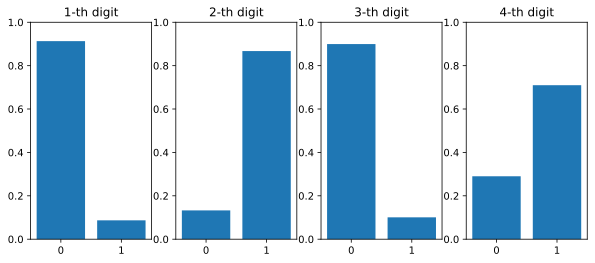

In [5]:
# Convert b to decimal
b_dec = sum([b[i]*2**(len(b)-1-i) for i in range(len(b))])

est_phase = b_dec/2**t
print("MAJORITY RULE")
print("Phase: {}".format(round(phase, 3)))
print("Estimated Phase: {}".format(est_phase))
print("Accuracy: {}".format(round(np.abs(phase - est_phase), 3)))
print("2^-(t+1) = {}".format(round(2**(-(t+1)), 3)))


plt.figure(figsize=(10,4))
for i in range(len(histograms)):
    plt.subplot(1, len(histograms), i+1)
    h = histograms[i]
    h = {int(key):val/shots for (key, val) in zip(h.keys(), h.values())}
    plt.title('{}-th digit'.format(i+1))
    plt.bar(h.keys(), h.values())
    plt.xticks([0, 1])
    plt.ylim([0, 1])
    plt.xlim([-0.5, 1.5])

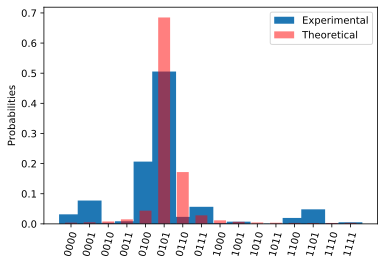

In [6]:
histograms

def merge(d1, d2):
    d = {}
    # Merge two histograms
    for key1 in list(d1.keys()):
        for key2 in list(d2.keys()):
               d[(key1+key2)]=(d1[key1]*d2[key2])
    return d

t_histogram = histograms[0]
for i in range(1, len(histograms)):
    t_histogram = merge(t_histogram, histograms[i])

t_histogram

def plot_histogram(answer):
    answer_dec = {bf_to_dec(key):value/shots**t for key, value in zip(answer.keys(), answer.values())}

    t_answer_dec = {key:p(key, phase) for key in answer_dec.keys()}


    plt.bar(answer_dec.keys(), answer_dec.values(), width=0.08, label='Experimental')
    plt.bar(t_answer_dec.keys(), t_answer_dec.values(), alpha=0.5, width=0.04, color='red', label='Theoretical')
    plt.xticks(list(answer_dec.keys()), list(answer.keys()), rotation=75)
    plt.legend()
    plt.ylabel('Probabilities')

plot_histogram(t_histogram)

# AVERAGE RULE

In [7]:
# First trigonometric moment about the mean direction
answer_dec = {bf_to_dec(key):value/shots**t for key, value in zip(t_histogram.keys(), t_histogram.values())}

theta_1 = np.sum([value*np.exp(2*np.pi*1j*key) for key, value in zip(answer_dec.keys(), answer_dec.values())])


est_phase = np.angle(theta_1)/(2*np.pi)

print('Estimated phase: {}'.format(est_phase))
print('Phase: {}'.format(round(phase, 3)))
print('Accuracy: {}'.format(round(np.abs(est_phase - phase), 3)))
print('2^-(t+2) = {}'.format(2**(-(t+2))))

mrl = np.absolute(theta_1)
sigma = np.sqrt(-2*np.log(mrl))/(2*np.pi)
print(sigma)

Estimated phase: 0.2819686120873435
Phase: 0.333
Accuracy: 0.051
2^-(t+2) = 0.015625
0.13598408007577595
